In [1]:
import pandas as pd
import nannyml as nml
import plotly.io as pio
pio.renderers.default = "svg"

#### Import work from Home Dataset
This case of use has been selected to explain NannyML features.
It includes performance estimation , data drift and alerts display.


The business challenge example we will be working on. We predict if a worker will work from home in a binary classification scenario on a given day. Each Dataset row contains a unique identified observation about a worker on a day of the week and considers several features, such as the distance from the office, transportation costs, and if the worker worked from home the previous day.
From that scenario , we want to do **performance estimation** without having access to the real target label. 


##### 1 ) Import Data 

The key concept here is to have into account reference and analysis partitions

* **Reference Partition**
The reference partition will have both the true predicted label and the predicted probability and we should know that it is data related to good model performance.

* **Analysis partition**
Analysis partition will only have the predicted probability and will refer to the absence of the ground truth.

In [2]:
reference, analysis, analysis_gt = nml.datasets.load_synthetic_sample()

In [3]:
reference.head(5)

,distance_from_office,salary_range,gas_price_per_litre,public_transportation_cost,wfh_prev_workday,workday,tenure,identifier,work_home_actual,timestamp,y_pred_proba,partition
0,5.962247,40K - 60K €,2.119485,8.568058,False,Friday,0.212653,0,1,2014-05-09 22:27:20,0.99,reference
1,0.535872,40K - 60K €,2.357199,5.425382,True,Tuesday,4.927549,1,0,2014-05-09 22:59:32,0.07,reference
2,1.969519,40K - 60K €,2.366849,8.247158,False,Monday,0.520817,2,1,2014-05-09 23:48:25,1.00,reference
3,2.530410,20K - 20K €,2.318722,7.944251,False,Tuesday,0.453649,3,1,2014-05-10 01:12:09,0.98,reference
4,2.253635,60K+ €,2.221265,8.884478,True,Thursday,5.695263,4,1,2014-05-10 02:21:34,0.99,reference


In [4]:
analysis.head(5)

,distance_from_office,salary_range,gas_price_per_litre,public_transportation_cost,wfh_prev_workday,workday,tenure,identifier,timestamp,y_pred_proba,partition
0,0.527691,0 - 20K €,1.800003,8.960724,False,Tuesday,4.224628,50000,2017-08-31 04:20:00,0.99,analysis
1,8.485134,20K - 20K €,2.222074,8.768792,False,Friday,4.963103,50001,2017-08-31 05:16:16,0.98,analysis
2,2.073876,40K - 60K €,2.310077,8.649979,True,Friday,4.588951,50002,2017-08-31 05:56:44,0.98,analysis
3,0.118456,20K - 20K €,2.171441,8.855418,False,Tuesday,4.711015,50003,2017-08-31 06:10:17,0.97,analysis
4,4.786705,0 - 20K €,2.368541,8.394966,False,Monday,0.906738,50004,2017-08-31 06:29:38,0.92,analysis


##### 2 ) Extract metadata

Extract metadata from the reference partition and set the target variable.
The metadata shows useful information that NannyML needs under the hood.
Besides, it shows data types from other columns 

In [5]:
metadata = nml.extract_metadata(reference)
metadata.target_column_name = 'work_home_actual'
metadata.print()

Metadata for model ~ UNKNOWN ~

# Warning - unable to identify all essential data
# Please identify column names for all '~ UNKNOWN ~' values

Model problem                       binary_classification              

Identifier column                   identifier                         
Timestamp column                    timestamp                          
Partition column                    partition                          
Prediction column                   ~ UNKNOWN ~                        
Predicted probability column        y_pred_proba                       
Target column                       work_home_actual                   

Features

Name                                Column                              Type            Description
distance_from_office                distance_from_office                continuous      extracted feature: distance_from_office
salary_range                        salary_range                        categorical     extracted feature: salary

##### 3 ) Fit estimator and estimate

Confidence-based Performance Estimation.
As main arguments, we need to pass metadata plus specify chunking method

In [6]:
cbpe = nml.CBPE(model_metadata=metadata, chunk_size=5000)
cbpe.fit(reference_data=reference)

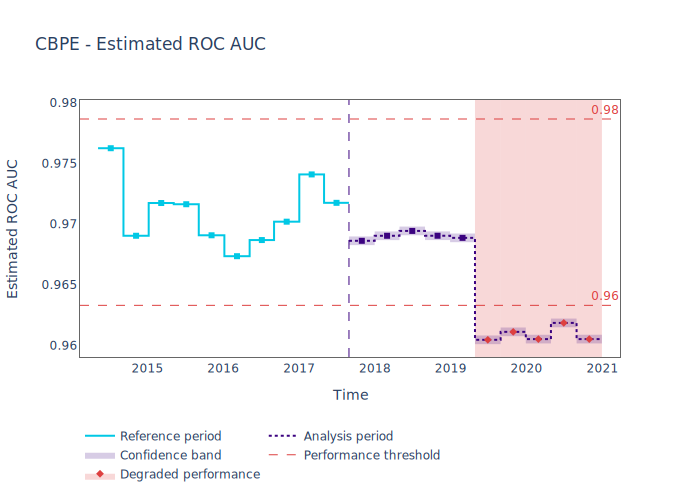

In [7]:
est_perf = cbpe.estimate(pd.concat([reference, analysis], ignore_index=True))
fig = est_perf.plot(kind='performance')
fig.show()

From the plot we can see that there is a drop in the performance estimation from 2019 to 2021 . In order to see what happened more in depth , we will plot drift for all available data

#### 4) Plot  Univariate data drift
We plot data drift for both continual and categorical features. In order to complete the task we need to instantiate an object that will perform Univariate Drift calculations.

In [8]:
univariate_calculator = nml.UnivariateStatisticalDriftCalculator(model_metadata=metadata, chunk_size=5000)
univariate_calculator.fit(reference_data=reference)
data = pd.concat([reference, analysis], ignore_index=True)
univariate_results = univariate_calculator.calculate(data=data)

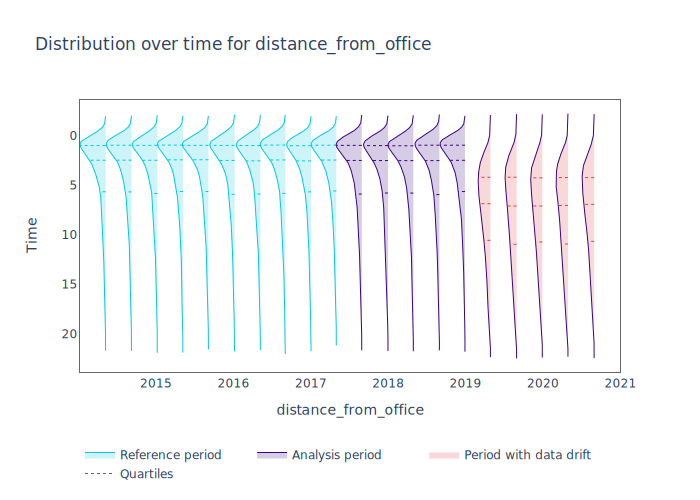

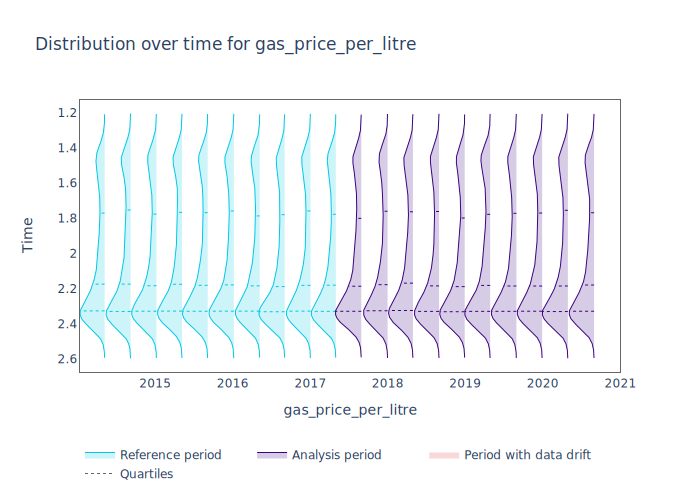

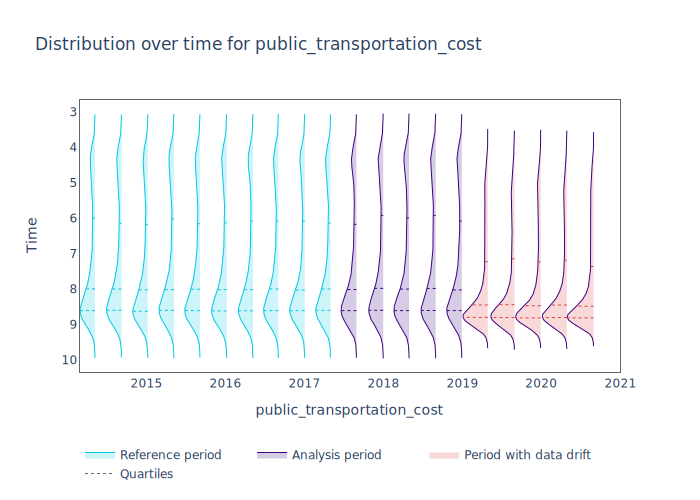

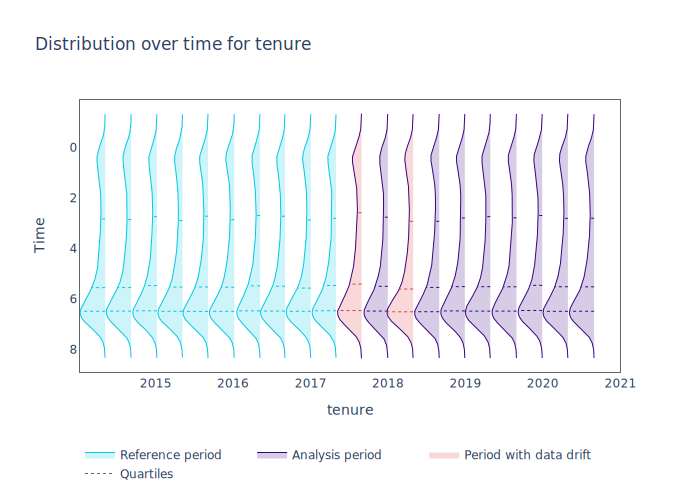

In [9]:
for feature in metadata.continuous_features: 
    figure = univariate_results.plot(
        kind='feature_distribution',
        feature_label=feature.label
    )
    figure.show()

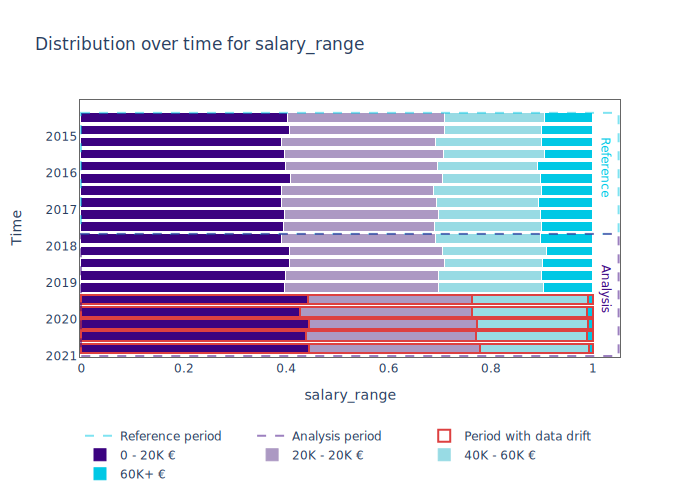

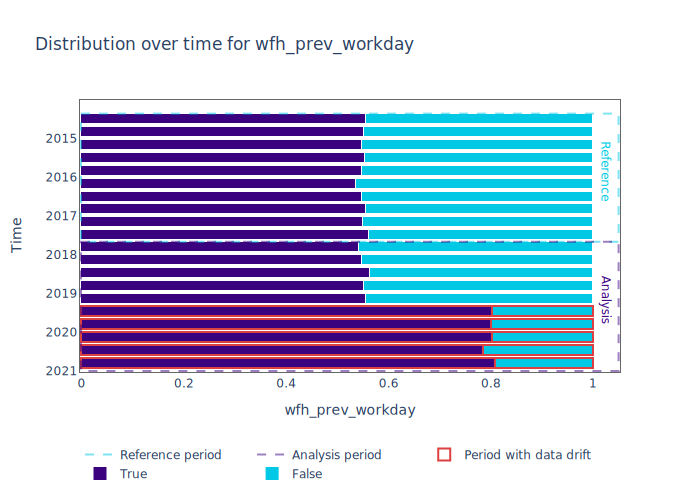

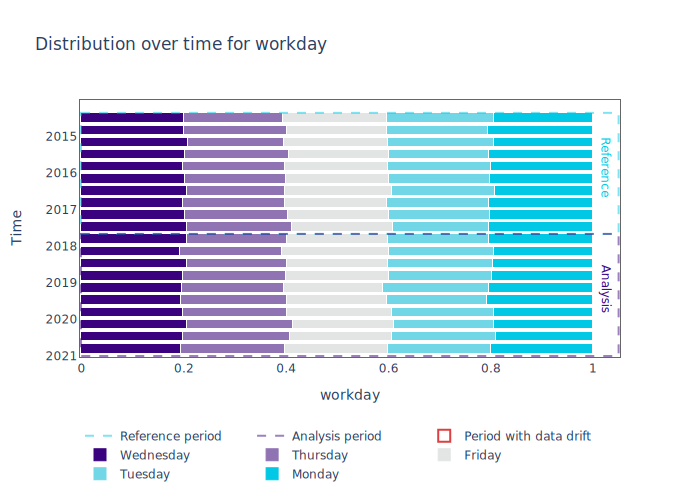

In [10]:
for feature in metadata.categorical_features:
     figure = univariate_results.plot(
         kind='feature_distribution',
             feature_label=feature.label
     )
     figure.show()

#### 5) Show alerts
NannyML creates a dataset ranking features according to how many alerts they have.

In [11]:
ranker = nml.Ranker.by('alert_count')
ranked_features = ranker.rank(univariate_results, model_metadata=metadata, only_drifting=False)
ranked_features

,feature,number_of_alerts,rank
0,salary_range,5,1
1,wfh_prev_workday,5,2
2,distance_from_office,5,3
3,public_transportation_cost,5,4
4,tenure,2,5
5,workday,0,6
6,gas_price_per_litre,0,7
